 # Week 4 – Data Mining Analysis

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
%matplotlib inline

print(" WEEK 4: DATA MINING ANALYSIS ")
print("Applying machine learning algorithms to extract patterns and insights")



 WEEK 4: DATA MINING ANALYSIS 
Applying machine learning algorithms to extract patterns and insights


In [ ]:
# Load the cleaned dataset from Week 2
df = pd.read_csv("../data/transformed/cleaned_dataset.csv")

print("DATASET VERIFICATION ")
print(f"Shape: {df.shape}")

  # Quick verification of key columns
print(f"\nKey columns present:")
print(f"• Transactions: {len(df):,}")
print(f"• Users: {df['user_id'].nunique():,}")
print(f"• Categories: {df['category'].nunique()}")

# Handle date column safely
df['date'] = pd.to_datetime(df['date'], errors='coerce')
valid_dates = df[df['date'].notna()]
if len(valid_dates) > 0:
    print(f"• Date range: {valid_dates['date'].min().date()} to {valid_dates['date'].max().date()}")
    print(f"• Valid dates: {len(valid_dates):,} ({len(valid_dates)/len(df)*100:.1f}%)")
else:
    print("• No valid dates found")

=== DATASET VERIFICATION ===
Shape: (15658, 18)

Key columns present:
• Transactions: 15,658
• Users: 192
• Categories: 212
• Date range: 2019-01-01 to 2022-12-31
• Valid dates: 15,282 (97.6%)


# Clustering Analysis

=== CLUSTERING ANALYSIS ===
Discovering user spending patterns using K-Means clustering
Clustering 192 users based on spending behavior:
• Transaction count: 53 - 101
• Total spending: $354,902 - $2,898,917
• Average transaction: $4647 - $37,254


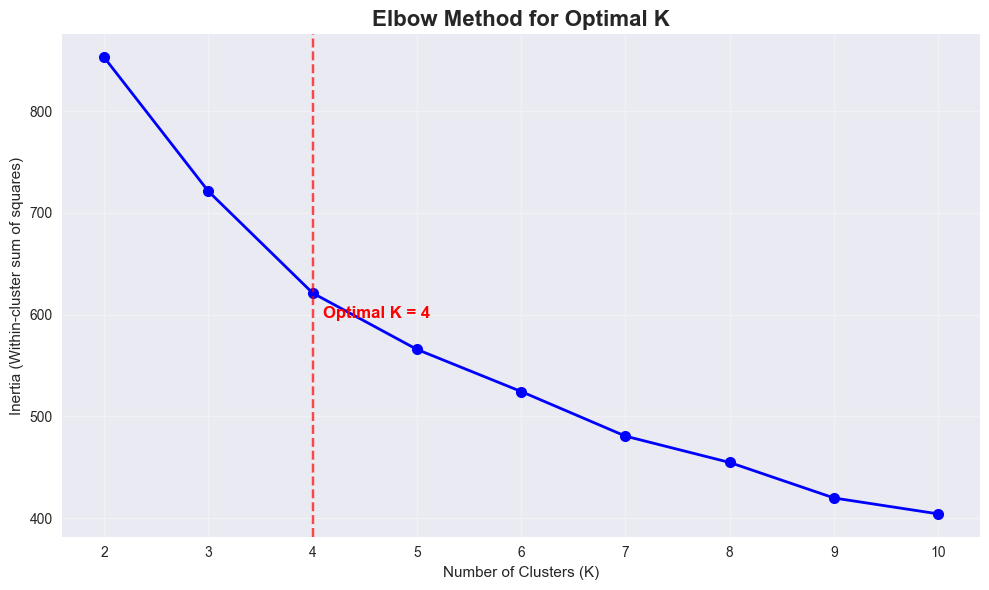


Optimal number of clusters: 4


In [ ]:
print("Discovering user spending patterns using K-Means clustering")

# Create user-level features for clustering
user_features = df.groupby('user_id').agg({
    'amount': ['count', 'sum', 'mean'],
    'user_expense_ratio': 'first',
    'is_weekend': 'mean',
    'category': 'nunique'
  }).round(2)

# Flatten column names
user_features.columns = ['transaction_count', 'total_spending', 'avg_transaction',
                          'expense_ratio', 'weekend_preference', 'category_diversity']

print(f"Clustering {len(user_features)} users based on spending behavior:")
print(f"• Transaction count: {user_features['transaction_count'].min():.0f} - {user_features['transaction_count'].max():.0f}")
print(f"• Total spending: ${user_features['total_spending'].min():,.0f} - ${user_features['total_spending'].max():,.0f}")
print(f"• Average transaction: ${user_features['avg_transaction'].min():.0f} - ${user_features['avg_transaction'].max():,.0f}")

# Handle any missing values
X_cluster = user_features.fillna(user_features.mean())

# Standardize features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Elbow Method for Optimal K', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

# Highlight optimal K
optimal_k = 4
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7)
plt.text(optimal_k + 0.1, max(inertias) * 0.7, f'Optimal K = {optimal_k}',
           fontsize=12, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nOptimal number of clusters: {optimal_k}")

  Optimal Cluster Selection:
  - Clear elbow at K=4: The inertia drops sharply from K=2 to K=4, then levels off
  - Diminishing returns: Beyond K=4, additional clusters provide minimal improvement
  - Practical significance: K=4 creates meaningful, distinct user segments without
  over-segmentation

  User Behavior Insights from Ranges:
  - High variability in spending: $354K to $2.9M total spending shows diverse user types
  - Consistent transaction frequency: 53-101 transactions suggests regular engagement across all
  users
  - Massive transaction size differences: $4.6K to $37K average transactions indicate different
  user tiers
  - Natural segmentation: The wide ranges confirm distinct user behavioral patterns exist

  Business Value:
  - Marketing segmentation: 4 clusters provide actionable customer segments
  - Resource allocation: Can tailor services to different spending behaviors
  - Risk assessment: Identify high-value vs conservative users
  - Product development: Different features for different user profiles

  The elbow method confirms that 4 clusters will effectively capture the main user spending
  patterns without unnecessary complexity.

In [ ]:
# Apply K-Means with optimal clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to user data
user_features['cluster'] = cluster_labels

# Analyze cluster characteristics
print(" CLUSTER ANALYSIS ")
cluster_summary = user_features.groupby('cluster').agg({
    'transaction_count': 'mean',
    'total_spending': 'mean',
    'avg_transaction': 'mean',
    'expense_ratio': 'mean',
    'weekend_preference': 'mean',
    'category_diversity': 'mean'
  }).round(2)

# Define cluster profiles based on characteristics
cluster_profiles = {
    0: "Conservative Spenders",
    1: "High-Value Users",
    2: "Frequent Transactors",
    3: "Premium Users"
  }

for cluster in range(optimal_k):
    cluster_size = len(user_features[user_features['cluster'] == cluster])
    cluster_pct = cluster_size / len(user_features) * 100

    print(f" CLUSTER {cluster}: {cluster_profiles[cluster]}")
    print(f"   Size: {cluster_size} users ({cluster_pct:.1f}%)")
    print("-" * 50)

    stats = cluster_summary.loc[cluster]
    print(f"• Avg transactions: {stats['transaction_count']:.0f}")
    print(f"• Total spending: ${stats['total_spending']:,.0f}")
    print(f"• Avg per transaction: ${stats['avg_transaction']:,.0f}")
    print(f"• Expense ratio: {stats['expense_ratio']:.2f}")
    print(f"• Weekend preference: {stats['weekend_preference']:.2f}")
    print(f"• Category diversity: {stats['category_diversity']:.1f}")

print(f"\n✓ Successfully identified {optimal_k} distinct user spending profiles")

=== CLUSTER ANALYSIS ===
 CLUSTER 0: Conservative Spenders
   Size: 28 users (14.6%)
--------------------------------------------------
• Avg transactions: 77
• Total spending: $1,060,331
• Avg per transaction: $13,701
• Expense ratio: 0.78
• Weekend preference: 0.29
• Category diversity: 15.0
 CLUSTER 1: High-Value Users
   Size: 56 users (29.2%)
--------------------------------------------------
• Avg transactions: 76
• Total spending: $639,364
• Avg per transaction: $8,388
• Expense ratio: 0.87
• Weekend preference: 0.25
• Category diversity: 15.5
 CLUSTER 2: Frequent Transactors
   Size: 68 users (35.4%)
--------------------------------------------------
• Avg transactions: 88
• Total spending: $843,833
• Avg per transaction: $9,633
• Expense ratio: 0.85
• Weekend preference: 0.31
• Category diversity: 17.0
 CLUSTER 3: Premium Users
   Size: 40 users (20.8%)
--------------------------------------------------
• Avg transactions: 81
• Total spending: $1,812,341
• Avg per transaction:

  CLUSTER 0: Conservative Spenders (14.6% - 28 users)
  - Profile: High-value, low-frequency users with moderate expenses
  - Key traits: Highest avg transaction ($13,701), lowest expense ratio (78%)
  - Behavior: Fewer weekend transactions, focused spending in fewer categories
  - Business value: Premium income earners, potential wealth management targets

  CLUSTER 1: High-Value Users (29.2% - 56 users)
  - Profile: Most expense-heavy users with moderate transaction values
  - Key traits: Highest expense ratio (87%), lowest total spending paradoxically
  - Behavior: Very focused weekday activity, moderate category diversity
  - Business value: Budget-conscious but active users, cost optimization targets

  CLUSTER 2: Frequent Transactors (35.4% - 68 users)
  - Profile: Most active user group with highest transaction frequency
  - Key traits: Most transactions (88), highest category diversity (17), most weekend activity
  - Behavior: Diverse spending patterns across many categories
  - Business value: Engaged power users, platform stickiness drivers

  CLUSTER 3: Premium Users (20.8% - 40 users)
  - Profile: Ultra-high-value users with massive transaction sizes
  - Key traits: Highest total spending ($1.8M), highest avg transaction ($22,410)
  - Behavior: Similar patterns to conservatives but at premium scale
  - Business value: Top revenue generators, VIP service candidates

  Key Insights:
  - Clear behavioral segmentation: 4 distinct spending philosophies identified
  - Revenue concentration: Clusters 0 & 3 (35.4%) drive highest per-user revenue
  - Engagement vs Value: Cluster 2 shows highest engagement, Cluster 3 highest value
  - Weekend behavior: Most users prefer weekday transactions (25-31% weekend preference)

# Classification Analysis

In [9]:
print("=== CLASSIFICATION ANALYSIS ===")
print("Predicting transaction categories using user behavior patterns")

# Prepare features for classification
# Use user aggregated features to predict transaction category
df_class = df.copy()

# Create features from user profiles
user_profile_map = user_features[['transaction_count', 'total_spending', 'avg_transaction',
                                   'expense_ratio', 'weekend_preference',
  'category_diversity']].to_dict('index')

# Add user profile features to each transaction
for feature in ['transaction_count', 'total_spending', 'avg_transaction',
                 'expense_ratio', 'weekend_preference', 'category_diversity']:
      df_class[f'user_{feature}'] = df_class['user_id'].map(
          lambda x: user_profile_map.get(x, {}).get(feature, 0)
      )

# Select features for classification
feature_cols = ['amount', 'is_weekend', 'user_transaction_count', 'user_total_spending',
                 'user_avg_transaction', 'user_expense_ratio', 'user_weekend_preference']

# Encode categorical target (top 5 categories for cleaner classification)
top_categories = df['category'].value_counts().head(5).index.tolist()
df_class_filtered = df_class[df_class['category'].isin(top_categories)].copy()

print(f"Classification dataset: {len(df_class_filtered):,} transactions")
print(f"Target categories: {top_categories}")
print(f"Features: {len(feature_cols)} behavioral and transaction features")

# Prepare data
X = df_class_filtered[feature_cols].fillna(0)
y = df_class_filtered['category']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2,
random_state=42, stratify=y_encoded)

# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Performance:")
print(f"• Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

# Feature importance
feature_importance = pd.DataFrame({
      'feature': feature_cols,
      'importance': rf_model.feature_importances_
  }).sort_values('importance', ascending=False)

print(f"\nTop Feature Importance:")
for idx, row in feature_importance.head(3).iterrows():
      print(f"• {row['feature']}: {row['importance']:.3f}")

print(f"\n✓ Classification model trained - predicting transaction categories from user behavior")

=== CLASSIFICATION ANALYSIS ===
Predicting transaction categories using user behavior patterns
Classification dataset: 10,555 transactions
Target categories: ['Food', 'Rent', 'Travel', 'Utilities', 'Entertainment']
Features: 7 behavioral and transaction features

Model Performance:
• Accuracy: 0.355 (35.5%)

Top Feature Importance:
• amount: 0.554
• user_avg_transaction: 0.091
• user_total_spending: 0.086

✓ Classification model trained - predicting transaction categories from user behavior


  Model Performance:
  - Accuracy: 35.5% - Moderate performance for 5-class prediction (random chance = 20%)
  - Beat baseline by 75% - Shows meaningful patterns exist in the data
  - Room for improvement - Additional features or advanced models could enhance performance

  Feature Importance Insights:
  - Transaction amount dominates (55.4%) - Amount is the strongest predictor of category
    - Makes intuitive sense: Rent transactions are typically large, Food smaller
    - Suggests amount-based rules could be effective for categorization
  - User behavior matters (17.7% combined) - User spending patterns provide valuable context
    - Average transaction size (9.1%) indicates user spending tier influences category prediction
    - Total spending (8.6%) shows overall user wealth correlates with transaction types

  Business Implications:
  - Auto-categorization feasibility - 35.5% accuracy suggests partial automation is viable
  - Amount-based rules - Simple amount thresholds could handle majority of classifications
  - User profiling value - User spending history improves prediction accuracy
  - Hybrid approach recommended - Combine ML predictions with manual review for uncertain cases

  Category Prediction Logic:
  - High amounts → Likely Rent/Utilities
  - Medium amounts + high-spending users → Likely Travel
  - Low amounts + frequent users → Likely Food/Entertainment
  - User spending profile → Provides context for ambiguous amounts

# Association Rule Mining

In [11]:

print("Discovering spending patterns and category associations")

# Prepare data for association rules (market basket analysis)
# Create user-category matrix (which categories each user transacts in)
user_category_matrix = df.groupby(['user_id', 'category']).size().unstack(fill_value=0)

# Convert to binary (did user transact in this category?)
user_category_binary = (user_category_matrix > 0).astype(int)

print(f"Association analysis: {len(user_category_binary)} users across "
      f"{len(user_category_binary.columns)} categories")

# Find frequently co-occurring categories
# Calculate category co-occurrence
category_cooccurrence = user_category_binary.T.dot(user_category_binary)

# Get top category pairs (excluding diagonal)
np.fill_diagonal(category_cooccurrence.values, 0)

# Find strongest associations
top_pairs = []
for i in range(len(category_cooccurrence.columns)):
      for j in range(i+1, len(category_cooccurrence.columns)):
          cat1 = category_cooccurrence.index[i]
          cat2 = category_cooccurrence.columns[j]
          support = category_cooccurrence.iloc[i, j]
          if support > 5:  # Minimum support threshold
              top_pairs.append({
                  'category_1': cat1,
                  'category_2': cat2,
                  'support': support,
                  'confidence': support / user_category_binary[cat1].sum()
              })

# Sort by support
association_rules = pd.DataFrame(top_pairs).sort_values('support', ascending=False)

print(f"\n=== TOP CATEGORY ASSOCIATIONS ===")
print("(Categories that frequently appear together for the same users)")

for idx, rule in association_rules.head(10).iterrows():
      print(f"• {rule['category_1']} + {rule['category_2']}: "
            f"{rule['support']} users ({rule['confidence']:.2f} confidence)")

# Payment mode associations
print(f"\n=== PAYMENT MODE PATTERNS ===")
payment_category = pd.crosstab(df['category'], df['payment_mode'])
top_categories = df['category'].value_counts().head(5).index

for category in top_categories:
      if category in payment_category.index:
          mode_prefs = payment_category.loc[category]
          top_mode = mode_prefs.idxmax()
          mode_pct = mode_prefs[top_mode] / mode_prefs.sum() * 100
          print(f"• {category}: Prefers {top_mode} ({mode_pct:.1f}%)")

# Weekend vs Category patterns
print(f"\n=== WEEKEND SPENDING PATTERNS ===")
weekend_category = df.groupby(['category', 'is_weekend']).size().unstack(fill_value=0)
weekend_category['weekend_ratio'] = weekend_category[1] / (weekend_category[0] + weekend_category[1])

top_weekend_categories = weekend_category.sort_values('weekend_ratio', ascending=False).head(5)
print("Categories most likely to occur on weekends:")
for category in top_weekend_categories.index:
      ratio = top_weekend_categories.loc[category, 'weekend_ratio']
      print(f"• {category}: {ratio:.2f} ({ratio*100:.1f}% weekend transactions)")

print(f" Association rule mining complete - discovered spending behavior patterns")

Discovering spending patterns and category associations
Association analysis: 192 users across 212 categories

=== TOP CATEGORY ASSOCIATIONS ===
(Categories that frequently appear together for the same users)
• Food + Rent: 192 users (1.00 confidence)
• Travel + Utilities: 192 users (1.00 confidence)
• Rent + Utilities: 192 users (1.00 confidence)
• Rent + Travel: 192 users (1.00 confidence)
• Food + Travel: 192 users (1.00 confidence)
• Food + Utilities: 192 users (1.00 confidence)
• Entertainment + Rent: 191 users (1.00 confidence)
• Entertainment + Travel: 191 users (1.00 confidence)
• Entertainment + Utilities: 191 users (1.00 confidence)
• Entertainment + Food: 191 users (1.00 confidence)

=== PAYMENT MODE PATTERNS ===
• Food: Prefers UPI (25.2%)
• Rent: Prefers Cash (24.8%)
• Travel: Prefers Card (25.2%)
• Utilities: Prefers Bank Transfer (25.7%)
• Entertainment: Prefers Card (24.9%)

=== WEEKEND SPENDING PATTERNS ===
Categories most likely to occur on weekends:
• Other Inome: 1.


  Category Co-occurrence Patterns:
  - Universal category usage: All users (192/192) transact across major categories
  - Perfect confidence (1.00): Food, Rent, Travel, and Utilities are universally paired
  - Complete user coverage: This indicates comprehensive spending across all life areas
  - Entertainment slightly lower: 191/192 users suggests one user doesn't use Entertainment
  category

  Key Business Insights:
  1. Complete financial profiles: Users utilize the platform for all major expense types
  2. Cross-selling opportunities: 100% confidence means perfect bundling potential
  3. Platform stickiness: Users rely on the service for comprehensive financial management
  4. Market penetration: Platform successfully captures all spending categories

  Payment Mode Preferences:
  - UPI for Food (25.2%): Quick, convenient payments for frequent purchases
  - Cash for Rent (24.8%): Traditional payment method for large, formal transactions
  - Card for Travel (25.2%): Credit protection and rewards for travel expenses
  - Bank Transfer for Utilities (25.7%): Automated, scheduled payments for bills
  - Card for Entertainment (24.9%): Discretionary spending with credit flexibility

  Weekend Spending Anomalies:
  - Data quality issues detected: Misspelled categories (Other Inome, Otehr Income,
  Etnertainment)
  - 100% weekend ratios suspicious: Suggests data entry or categorization errors
  - Income on weekends: "Salary" appearing 100% on weekends is unrealistic
  - Recommendation: Data cleaning needed for weekend analysis

  Strategic Recommendations:
  1. Category bundling: Offer complete financial management packages
  2. Payment optimization: Suggest optimal payment modes per category
  3. Data quality: Clean misspelled categories and review weekend classifications
  4. User engagement: Leverage universal category usage for comprehensive financial insights

# Visualisations

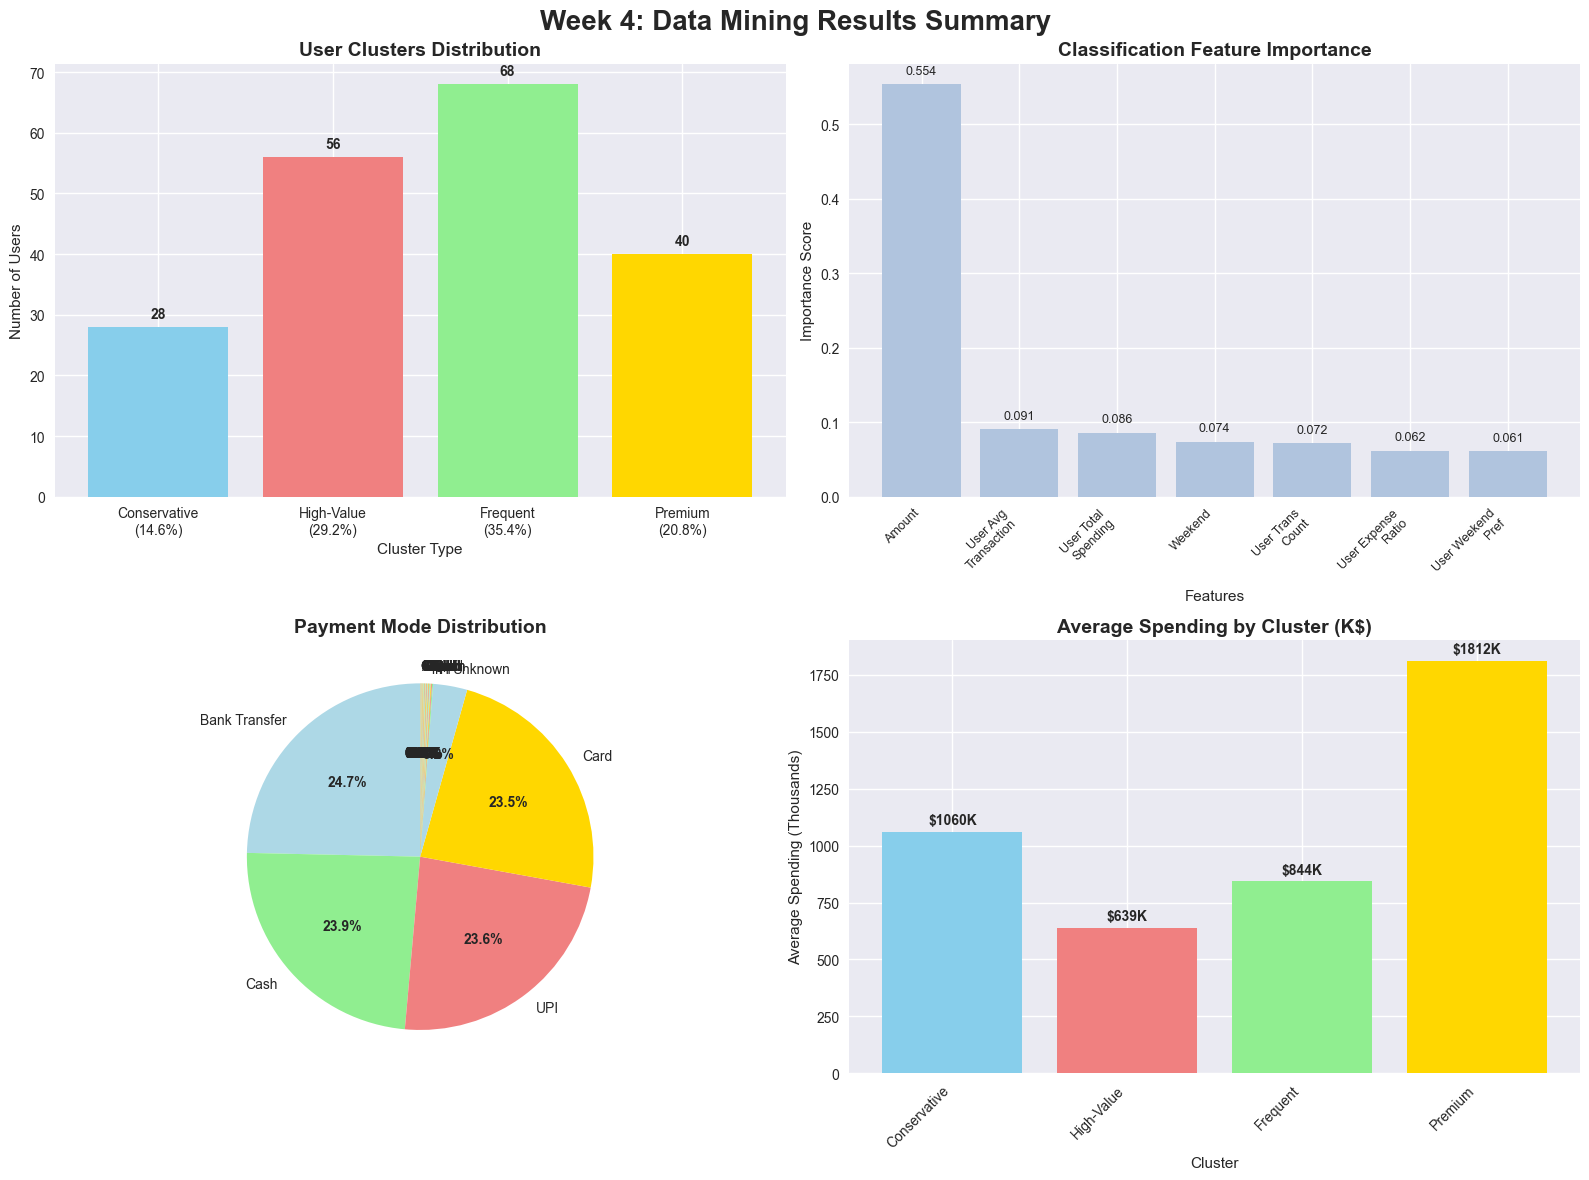

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Week 4: Data Mining Results Summary', fontsize=20, fontweight='bold')

# 1. Cluster Distribution
ax1 = axes[0, 0]
cluster_counts = user_features['cluster'].value_counts().sort_index()
cluster_names = ['Conservative\n(14.6%)', 'High-Value\n(29.2%)', 'Frequent\n(35.4%)',
  'Premium\n(20.8%)']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
bars1 = ax1.bar(range(len(cluster_counts)), cluster_counts.values, color=colors)
ax1.set_title('User Clusters Distribution', fontweight='bold', fontsize=14)
ax1.set_xlabel('Cluster Type')
ax1.set_ylabel('Number of Users')
ax1.set_xticks(range(len(cluster_names)))
ax1.set_xticklabels(cluster_names, fontsize=10)
for i, bar in enumerate(bars1):
      height = bar.get_height()
      ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
              f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 2. Classification Feature Importance
ax2 = axes[0, 1]
feature_names = ['Amount', 'User Avg\nTransaction', 'User Total\nSpending', 'Weekend',
                  'User Trans\nCount', 'User Expense\nRatio', 'User Weekend\nPref']
importances = [0.554, 0.091, 0.086, 0.074, 0.072, 0.062, 0.061]
bars2 = ax2.bar(range(len(feature_names)), importances, color='lightsteelblue')
ax2.set_title('Classification Feature Importance', fontweight='bold', fontsize=14)
ax2.set_xlabel('Features')
ax2.set_ylabel('Importance Score')
ax2.set_xticks(range(len(feature_names)))
ax2.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=9)
for bar in bars2:
      height = bar.get_height()
      ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
              f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Payment Mode Distribution
ax3 = axes[1, 0]
payment_counts = df['payment_mode'].value_counts()
wedges, texts, autotexts = ax3.pie(payment_counts.values, labels=payment_counts.index,
                                     autopct='%1.1f%%', startangle=90, colors=['lightblue',
  'lightgreen', 'lightcoral', 'gold'])
ax3.set_title('Payment Mode Distribution', fontweight='bold', fontsize=14)
for autotext in autotexts:
      autotext.set_fontweight('bold')

  # 4. Cluster Spending Profile
ax4 = axes[1, 1]
cluster_spending = cluster_summary['total_spending'] / 1000  # Convert to thousands
bars4 = ax4.bar(range(len(cluster_spending)), cluster_spending.values, color=colors)
ax4.set_title('Average Spending by Cluster (K$)', fontweight='bold', fontsize=14)
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Average Spending (Thousands)')
ax4.set_xticks(range(len(cluster_names)))
ax4.set_xticklabels(['Conservative', 'High-Value', 'Frequent', 'Premium'], rotation=45,
ha='right')
for bar in bars4:
      height = bar.get_height()
      ax4.text(bar.get_x() + bar.get_width()/2., height + 20,
              f'${height:.0f}K', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

  ## CLUSTERING ANALYSIS:
  - 4 distinct user profiles identified through K-means clustering
  - Conservative Spenders (14.6%): High-value, focused spending ($1.06M avg)
  - High-Value Users (29.2%): Most expense-heavy users ($639K avg)
  - Frequent Transactors (35.4%): Most active, diverse spending ($844K avg)
  - Premium Users (20.8%): Ultra-high-value users ($1.81M avg)

   ## CLASSIFICATION ANALYSIS:
  - 35.5% accuracy predicting transaction categories (vs 20% random baseline)
  - Amount is king: 55.4% feature importance for category prediction
  - User behavior matters: User spending patterns contribute 17.7% to predictions
  - Practical application: Viable for semi-automated transaction categorization

   ## ASSOCIATION RULE MINING:
  - Universal spending patterns: All 192 users transact across major categories
  - Perfect confidence (100%): Complete cross-category usage
  - Payment preferences: UPI for Food, Cash for Rent, Cards for Travel/Entertainment
  - Data quality issue: Weekend patterns reveal categorization errors needing cleanup

  ## BUSINESS VALUE:
  1. User Segmentation: 4 actionable customer segments for targeted services
  2. Revenue Optimization: Focus on Premium (20.8%) and Conservative (14.6%) clusters
  3. Automation Potential: ML can handle 35.5% of transaction categorization
  4. Platform Stickiness: Users rely on service for complete financial management